In [ ]:
# Furniture Assembly Help System Analysis
# ===================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import combinations
import networkx as nx
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
%matplotlib inline

# Set the plotting style and figure size for better visualizations
# plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("muted")

# Load and prepare the data
# -------------------------

# Read the data from the CSV file
data_raw = pd.read_csv('analysis_first_round_of_test.csv')

# The data has a unique structure where each participant's interactions are
# represented across multiple rows. Let's reshape it for easier analysis.

# First, identify participant IDs - fixing the boolean indexing issue
id_rows = data_raw.iloc[:, 0].astype(str).str.contains('ID', na=False)
participant_ids = data_raw.iloc[id_rows.to_numpy().nonzero()[0], 0].reset_index(drop=True)

# Extract the data sections for each participant
participant_data = []

for i in range(len(participant_ids)):
    # Fix indexing by using to_numpy to get indices where the condition is True
    start_idx = data_raw.iloc[:, 0][data_raw.iloc[:, 0] == participant_ids[i]].index[0]
    if i < len(participant_ids) - 1:
        end_idx = data_raw.iloc[:, 0][data_raw.iloc[:, 0] == participant_ids[i+1]].index[0]
    else:
        end_idx = len(data_raw)

    # Get the data for this participant
    part_data = data_raw.iloc[start_idx:end_idx].copy()

    # Set the participant ID
    part_data['participant_id'] = participant_ids[i]

    # Add step number (assuming each row represents a sequential step)
    part_data['step'] = range(1, len(part_data) + 1)

    participant_data.append(part_data)

# Combine all participant data
data = pd.concat(participant_data, ignore_index=True)

# Clean up column names and values
data.columns = ['raw_id', 'short_text_viewed', 'long_text_viewed', 'single_pieces_viewed',
                'assembly_viewed', 'video_viewed', 'participant_id', 'step']

# Replace participant IDs with just the number
data['participant_id'] = data['participant_id'].str.replace('ID ', '').astype(int)

# Set up multi-index for easier analysis
data = data.set_index(['participant_id', 'step'])

# Ensure all suggestion type columns are numeric
suggestion_columns = ['short_text_viewed', 'long_text_viewed', 'single_pieces_viewed',
                     'assembly_viewed', 'video_viewed']
for col in suggestion_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce').fillna(0)

In [ ]:
# Basic summary statistics
# =======================

print("Dataset Overview:")
print(f"Number of participants: {data.index.get_level_values(0).nunique()}")
print(f"Maximum steps per participant: {data.index.get_level_values(1).max()}")
print(f"Total interactions recorded: {len(data)}")

# Overall usage statistics
suggestion_usage = data[suggestion_columns].sum().sort_values(ascending=False)
print("\nOverall Suggestion Usage Counts:")
print(suggestion_usage)

# Create a summary dataframe of participant behaviors
participant_summaries = data.groupby('participant_id')[suggestion_columns].sum()

# Add percentage columns
for col in suggestion_columns:
    participant_summaries[f'{col}_pct'] = round(participant_summaries[col] / len(data.loc[participant_summaries.index[0]]) * 100, 1)

# Add total suggestions used by each participant
participant_summaries['total_suggestions'] = participant_summaries[suggestion_columns].sum(axis=1)

Dataset Overview:
Number of participants: 10
Maximum steps per participant: 16
Total interactions recorded: 160

Overall Suggestion Usage Counts:
short_text_viewed       101.0
assembly_viewed          70.0
single_pieces_viewed     55.0
long_text_viewed         31.0
video_viewed             26.0
dtype: float64


<ipython-input-3-540d5277ae57>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=suggestion_usage.index, y=suggestion_usage.values,


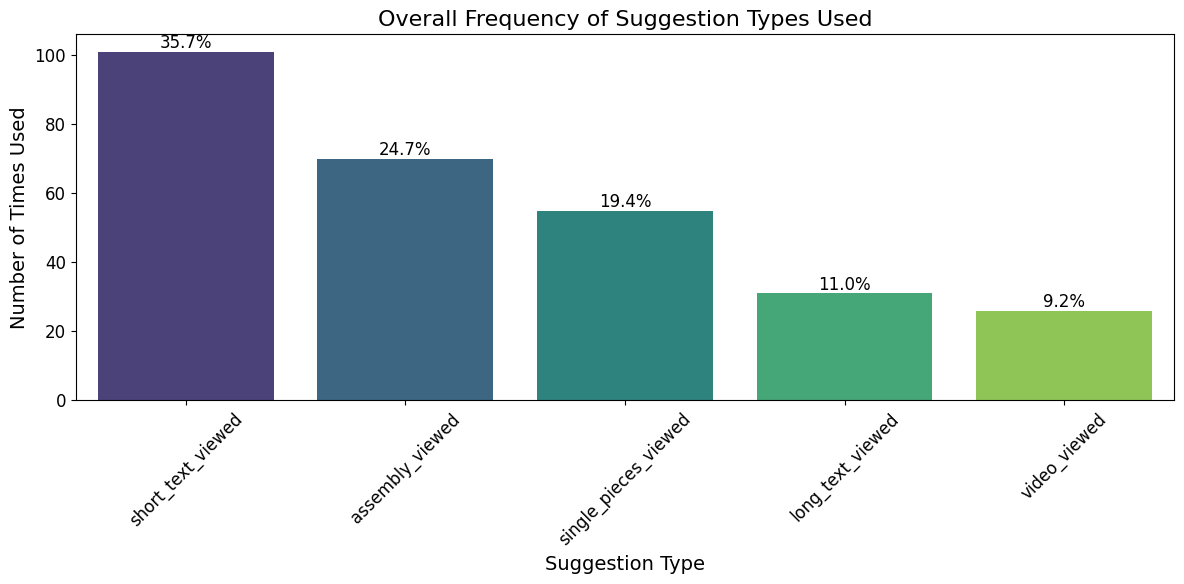

In [ ]:
# Visualization 1: Overall Suggestion Usage
# ========================================
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=suggestion_usage.index, y=suggestion_usage.values,
                palette='viridis')
plt.title('Overall Frequency of Suggestion Types Used', fontsize=16)
plt.xlabel('Suggestion Type', fontsize=14)
plt.ylabel('Number of Times Used', fontsize=14)
plt.xticks(rotation=45)

# Add percentage labels
total = suggestion_usage.sum()
for i, v in enumerate(suggestion_usage.values):
    ax.text(i, v + 1, f"{v/total*100:.1f}%", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

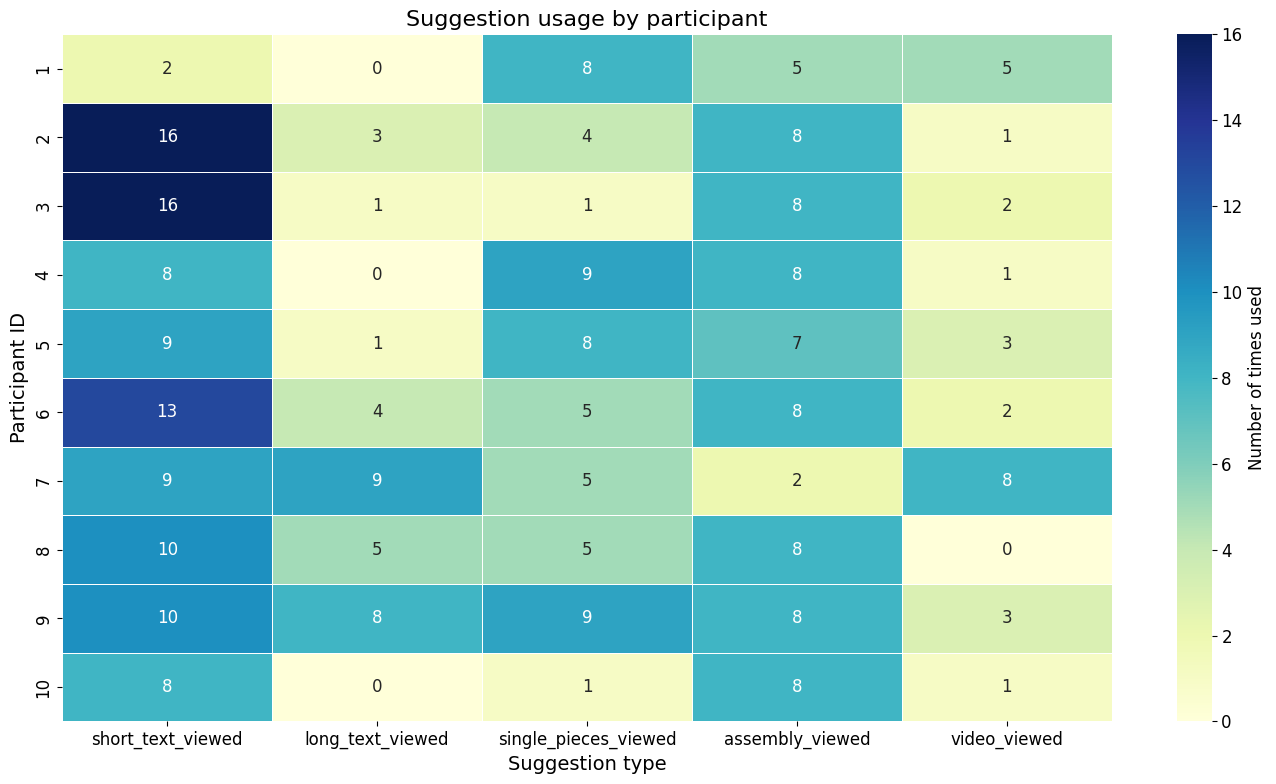

In [ ]:
# Visualization 2: Heatmap of suggestion usage by participant
# =========================================================
plt.figure(figsize=(14, 8))
sns.heatmap(participant_summaries[suggestion_columns], annot=True, cmap='YlGnBu', fmt='g',
           linewidths=.5, cbar_kws={'label': 'Number of times used'})
plt.title('Suggestion usage by participant', fontsize=16)
plt.xlabel('Suggestion type', fontsize=14)
plt.ylabel('Participant ID', fontsize=14)
plt.tight_layout()
plt.show()

<Figure size 1600x800 with 0 Axes>

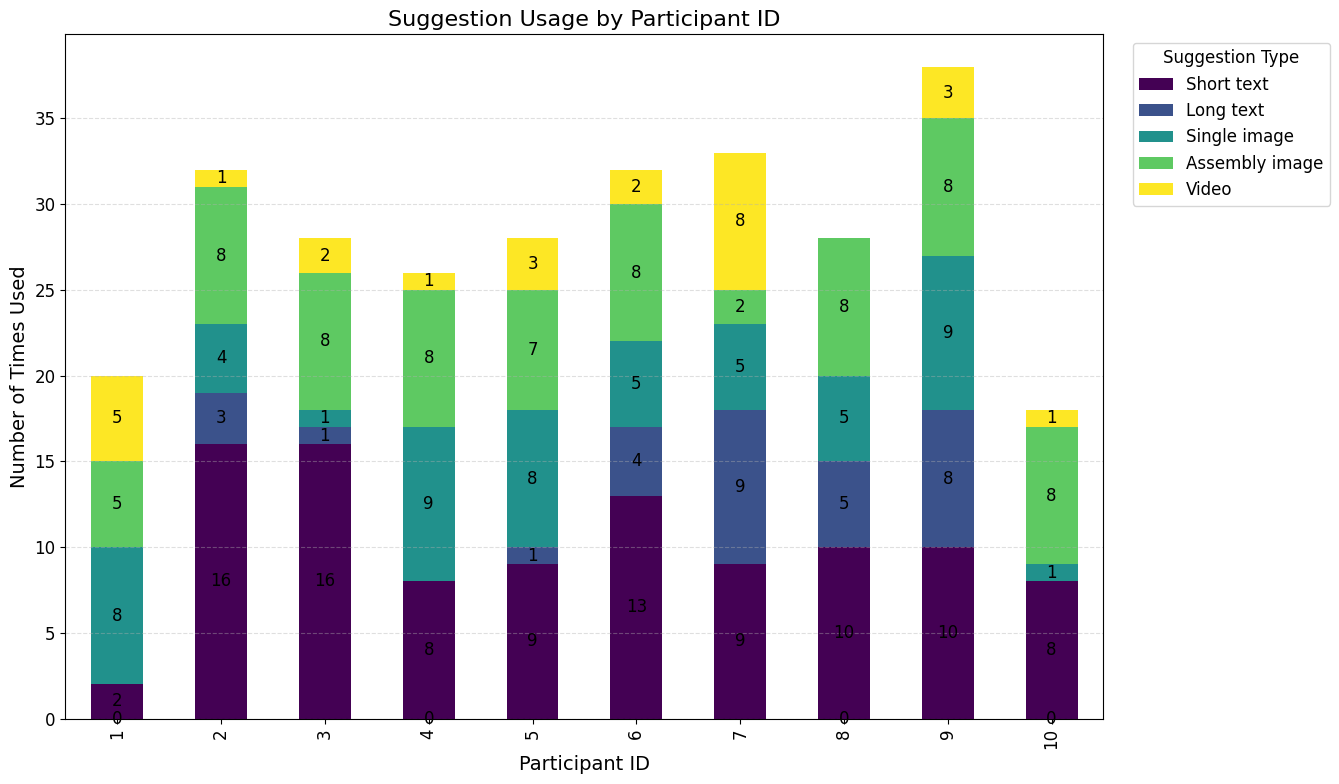

In [ ]:
# Reshape the data for plotting
melted_data = pd.melt(
    participant_summaries.reset_index(),
    id_vars=['participant_id'],
    value_vars=suggestion_columns,
    var_name='Suggestion Type',
    value_name='Count'
)
melted_data = melted_data.rename(columns={'index': 'participant_id'})

# Create a mapping dictionary for renaming
rename_dict = {
    # Assuming these are your original column names - adjust as needed
    suggestion_columns[0]: 'Short text',
    suggestion_columns[1]: 'Long text',
    suggestion_columns[2]: 'Single image',
    suggestion_columns[3]: 'Assembly image',
    suggestion_columns[4]: 'Video'
}

# Rename the suggestion types
melted_data['Suggestion Type'] = melted_data['Suggestion Type'].replace(rename_dict)

# Create the plot
plt.figure(figsize=(16, 8))

# Pivot the data to create a matrix suitable for stacked bar chart
pivot_data = melted_data.pivot_table(
    index='participant_id',
    columns='Suggestion Type',
    values='Count',
    fill_value=0
)

# Reorder the columns in the specified order
ordered_columns = ['Short text', 'Long text', 'Single image', 'Assembly image', 'Video']
pivot_data = pivot_data[ordered_columns]

# Plot the stacked bar chart
ax = pivot_data.plot(
    kind='bar',
    stacked=True,
    figsize=(16, 8),
    colormap='viridis'
)

# Customizing the plot
plt.title('Suggestion Usage by Participant ID', fontsize=16)
plt.xlabel('Participant ID', fontsize=14)
plt.ylabel('Number of Times Used', fontsize=14)
plt.legend(title='Suggestion Type', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Add count labels to each segment of the stacked bars
bars = ax.containers
for container in bars:
    ax.bar_label(container, label_type='center', fmt='%g')

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

<Figure size 1400x800 with 0 Axes>

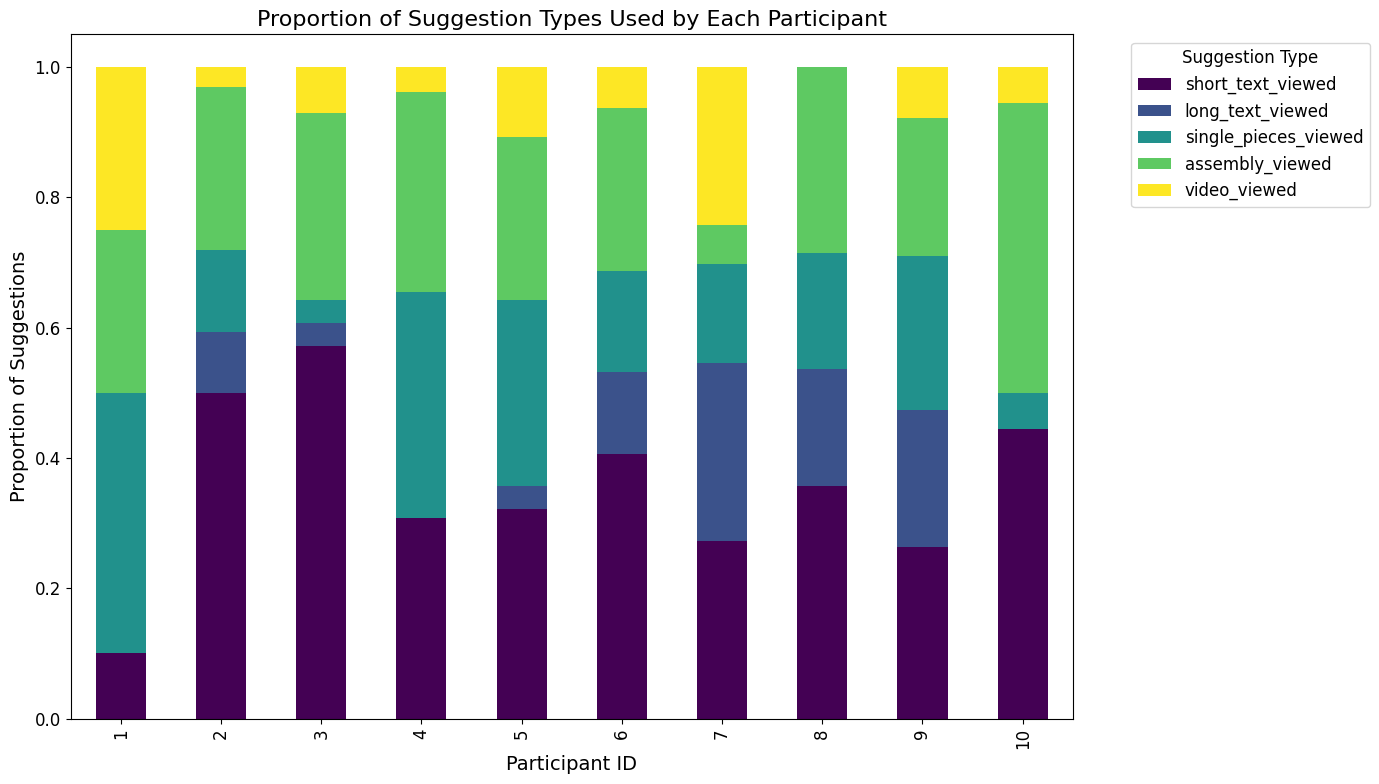

In [ ]:
# Visualization 3: Proportional usage by participant
# ================================================
# Calculate the proportion of each suggestion type for each participant
suggestion_props = participant_summaries[suggestion_columns].div(
    participant_summaries[suggestion_columns].sum(axis=1), axis=0)

plt.figure(figsize=(14, 8))
ax = suggestion_props.plot(kind='bar', stacked=True, figsize=(14, 8),
                         colormap='viridis')
plt.title('Proportion of Suggestion Types Used by Each Participant', fontsize=16)
plt.xlabel('Participant ID', fontsize=14)
plt.ylabel('Proportion of Suggestions', fontsize=14)
plt.legend(title='Suggestion Type', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.axhline(y=0.2, color='red', linestyle='--', alpha=0.5)  # Reference line for equal distribution
plt.tight_layout()
plt.show()

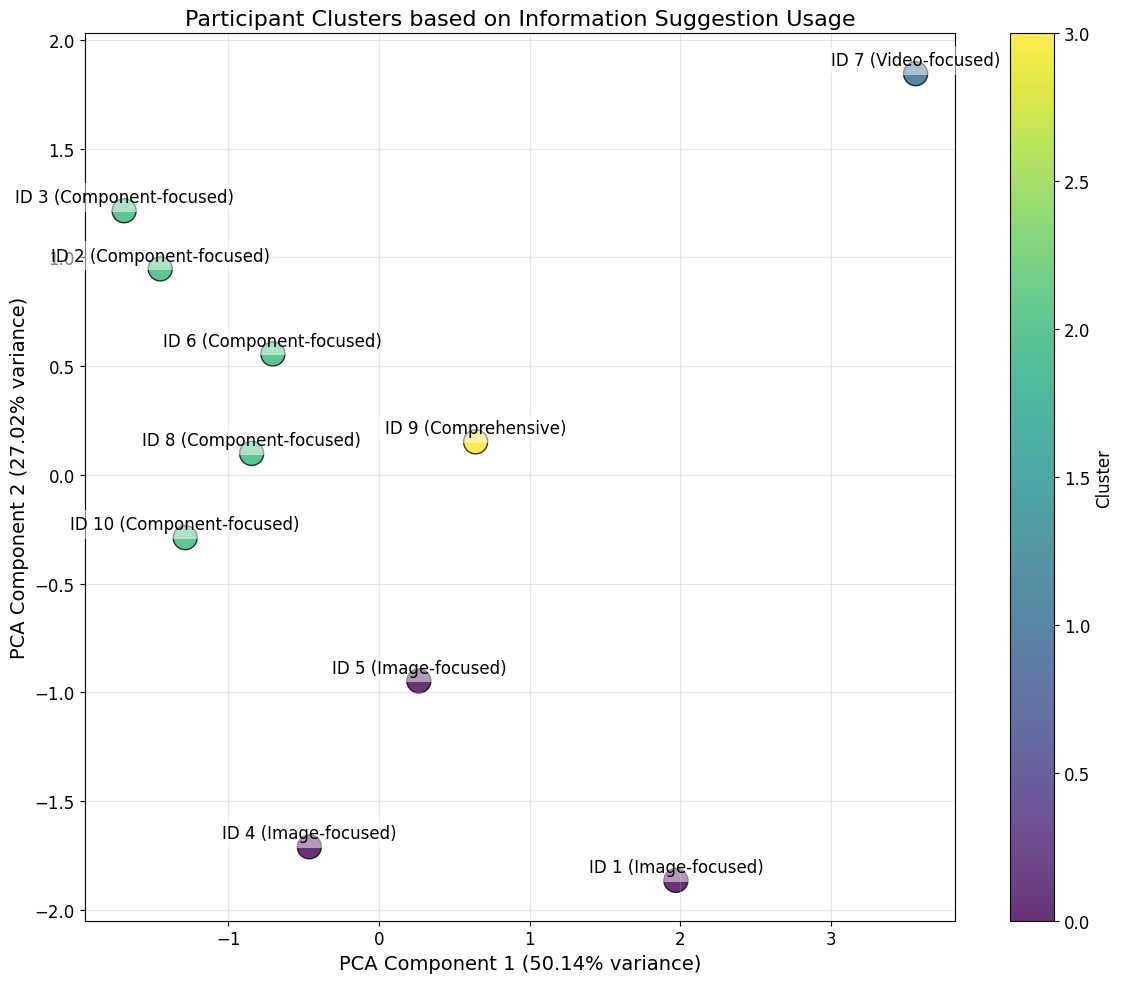


Cluster Characteristics:
         short_text_viewed  long_text_viewed  single_pieces_viewed  \
cluster                                                              
0                 6.333333          0.333333              8.333333   
1                 9.000000          9.000000              5.000000   
2                12.600000          2.600000              3.200000   
3                10.000000          8.000000              9.000000   

         assembly_viewed  video_viewed  
cluster                                 
0               6.666667           3.0  
1               2.000000           8.0  
2               8.000000           1.2  
3               8.000000           3.0  

Cluster 0 - Image-focused:
[1, 4, 5]
short_text_viewed       6.333333
long_text_viewed        0.333333
single_pieces_viewed    8.333333
assembly_viewed         6.666667
video_viewed            3.000000
Name: 0, dtype: float64

Cluster 1 - Video-focused:
[7]
short_text_viewed       9.0
long_text_viewed    

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Standardize the data for clustering
scaler = StandardScaler()
participant_features = scaler.fit_transform(participant_summaries[suggestion_columns])

# K-means clustering to identify user groups
kmeans = KMeans(n_clusters=4, random_state=42)
participant_summaries['cluster'] = kmeans.fit_predict(participant_features)

# Perform PCA
pca = PCA(n_components=2)
participant_pca = pca.fit_transform(participant_features)

# Define cluster names
cluster_names = {
    0: "Image-focused",
    1: "Video-focused",
    2: "Component-focused",
    3: "Comprehensive"
}

# Create figure
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    participant_pca[:, 0], participant_pca[:, 1],
    c=participant_summaries['cluster'], cmap='viridis',
    s=300, alpha=0.8, edgecolors='k'
)
plt.title('Participant Clusters based on Information Suggestion Usage', fontsize=16)
plt.xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=14)
plt.ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=14)

# Add participant IDs and cluster labels ABOVE the circles
for i, txt in enumerate(participant_summaries.index):
    cluster_label = cluster_names.get(participant_summaries['cluster'].iloc[i], "Unknown")
    plt.annotate(f'ID {txt} ({cluster_label})',
                 (participant_pca[i, 0], participant_pca[i, 1] + 0.02),  # Small offset above the circle
                 fontsize=12, ha='center', va='bottom',
                 bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Cluster characteristics
print("\nCluster Characteristics:")
cluster_profiles = participant_summaries.groupby('cluster')[suggestion_columns].mean()
print(cluster_profiles)

# Print detailed cluster info
for cluster, name in cluster_names.items():
    print(f"\nCluster {cluster} - {name}:")
    print(participant_summaries[participant_summaries['cluster'] == cluster].index.tolist())
    print(cluster_profiles.loc[cluster])


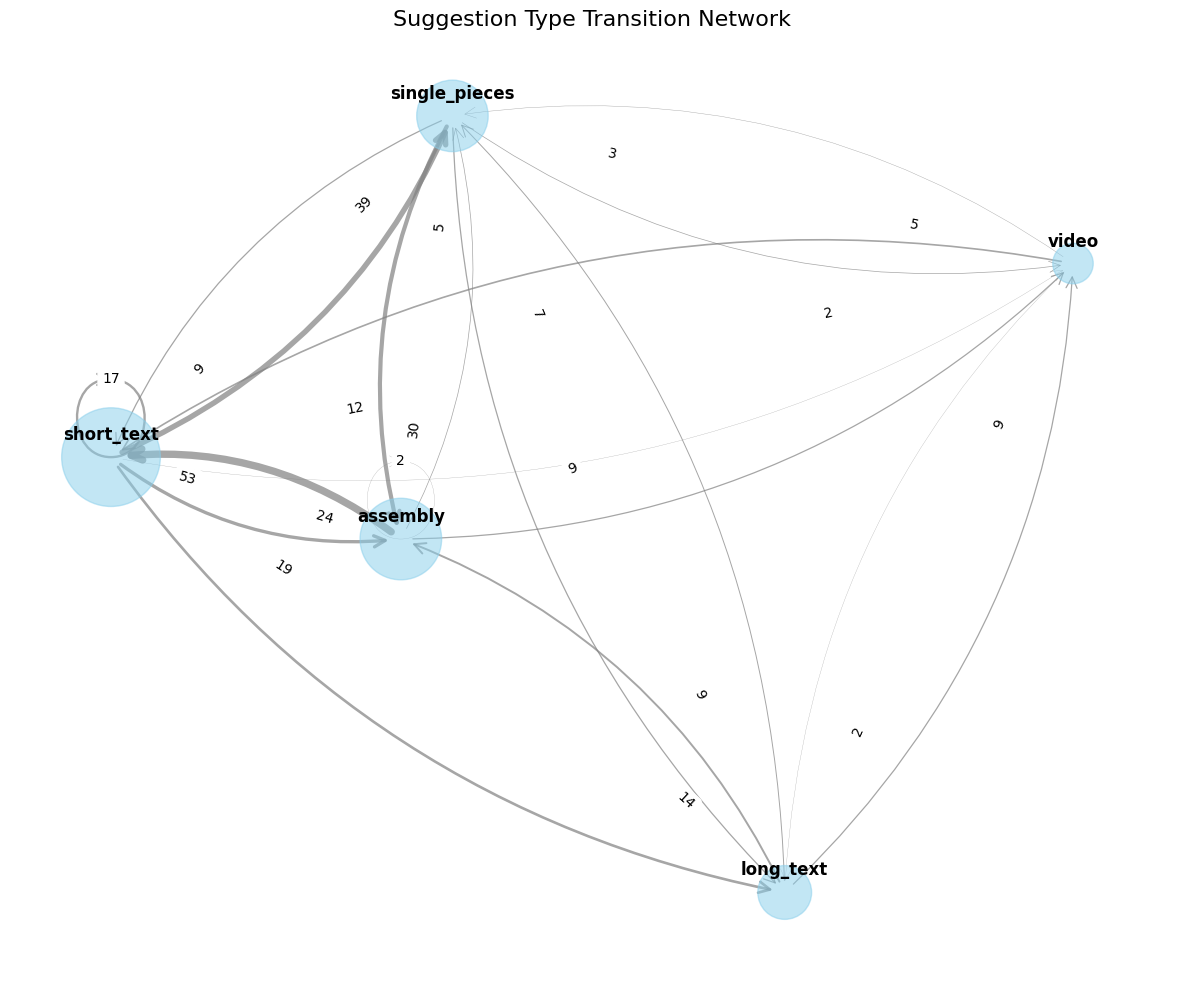

In [ ]:
# Sequence analysis - transitions between suggestion types
# ======================================================
# Create a transition matrix for each participant
transition_counts = {}

for participant_id in data.index.get_level_values(0).unique():
    participant_data = data.loc[participant_id]

    # Get the sequence of suggestion types for each step
    sequence = []
    for _, row in participant_data.iterrows():
        used_suggestions = [col.replace('_viewed', '') for col in suggestion_columns
                            if row[col] == 1.0]
        if used_suggestions:
            sequence.extend(used_suggestions)

    # Count transitions between suggestion types
    transitions = Counter()
    for i in range(len(sequence) - 1):
        transitions[(sequence[i], sequence[i+1])] += 1

    transition_counts[participant_id] = transitions

# Aggregate transitions across all participants
all_transitions = Counter()
for transitions in transition_counts.values():
    all_transitions.update(transitions)

# Create a directed graph of transitions
G = nx.DiGraph()
for (source, target), weight in all_transitions.items():
    if weight > 1:  # Only include transitions that happen more than once
        G.add_edge(source, target, weight=weight)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.5, seed=42)
edge_weights = [G[u][v]['weight'] * 0.1 for u, v in G.edges()]
node_sizes = [sum(G[node][neighbor]['weight'] for neighbor in G[node]) * 50 for node in G.nodes()]

# Offset node labels slightly to prevent overlap with arrows
label_pos_offset = {node: (x, y + 0.05) for node, (x, y) in pos.items()}  # Small Y-axis shift

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', alpha=0.5)
nx.draw_networkx_labels(G, label_pos_offset, font_size=12, font_weight='bold')  # Apply offset

# Use curved edges to distinguish bidirectional transitions
nx.draw_networkx_edges(
    G, pos, width=edge_weights, alpha=0.7, edge_color='gray',
    arrowsize=20, arrowstyle='->', connectionstyle="arc3,rad=0.2"
)

# Separate edge labels for forward and backward transitions
forward_labels = {(u, v): G[u][v]['weight'] for u, v in G.edges() if (v, u) not in G.edges()}
backward_labels = {(v, u): G[v][u]['weight'] for u, v in G.edges() if (v, u) in G.edges()}

# Draw labels with slight offset
nx.draw_networkx_edge_labels(G, pos, edge_labels=forward_labels, font_size=10, label_pos=0.25)
nx.draw_networkx_edge_labels(G, pos, edge_labels=backward_labels, font_size=10, label_pos=0.75)

plt.title('Suggestion Type Transition Network', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()


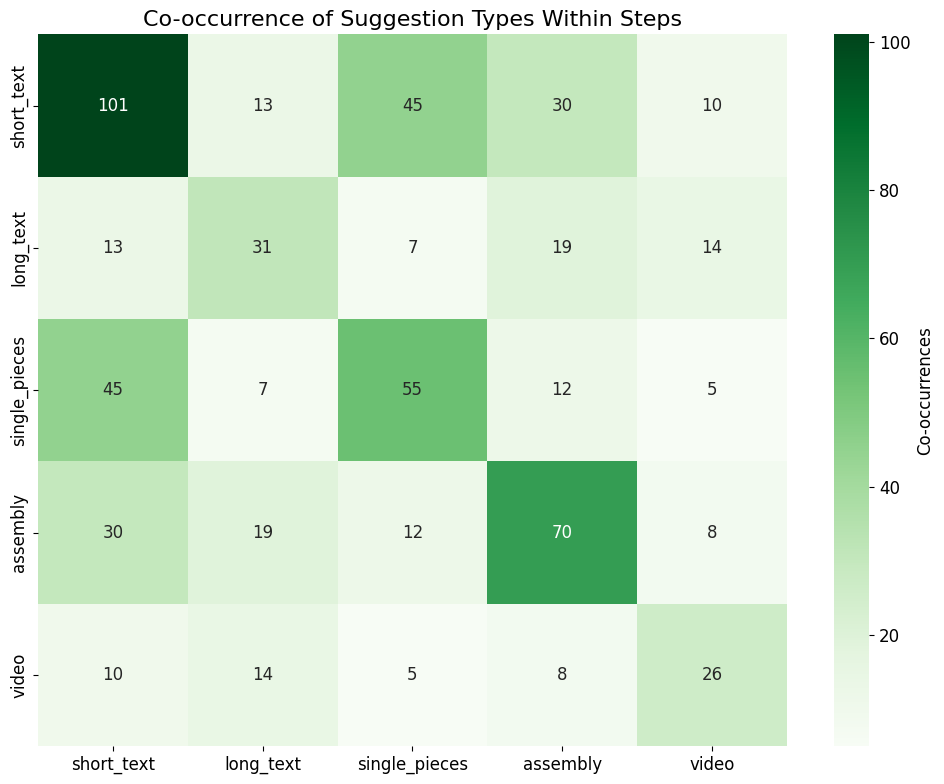

In [ ]:
# Co-occurrence analysis - which suggestion types are used together
# ===============================================================
# Create co-occurrence matrix
co_occurrence = np.zeros((len(suggestion_columns), len(suggestion_columns)))
for idx, row in data.iterrows():
    for i, col1 in enumerate(suggestion_columns):
        for j, col2 in enumerate(suggestion_columns):
            if row[col1] == 1.0 and row[col2] == 1.0:
                co_occurrence[i, j] += 1

co_occur_df = pd.DataFrame(co_occurrence,
                         index=[col.replace('_viewed', '') for col in suggestion_columns],
                         columns=[col.replace('_viewed', '') for col in suggestion_columns])

plt.figure(figsize=(10, 8))
sns.heatmap(co_occur_df, annot=True, cmap='Greens', fmt='g', cbar_kws={'label': 'Co-occurrences'})
plt.title('Co-occurrence of Suggestion Types Within Steps', fontsize=16)
plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

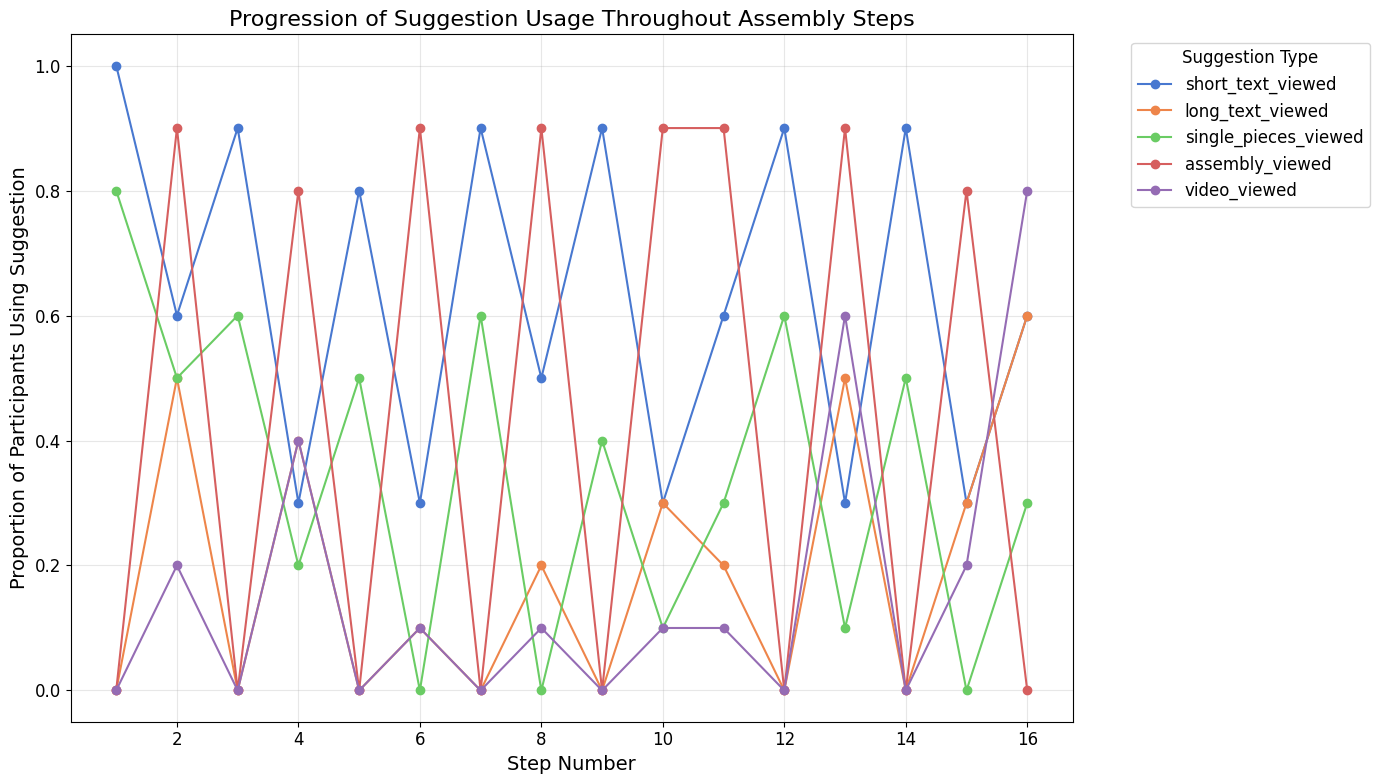

In [ ]:
# Step-wise progression analysis
# ============================
# Analyze which suggestion types are used at each step in the process
step_progression = data.groupby(level=1)[suggestion_columns].mean()

plt.figure(figsize=(14, 8))
step_progression.plot(kind='line', marker='o', figsize=(14, 8))
plt.title('Progression of Suggestion Usage Throughout Assembly Steps', fontsize=16)
plt.xlabel('Step Number', fontsize=14)
plt.ylabel('Proportion of Participants Using Suggestion', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(title='Suggestion Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

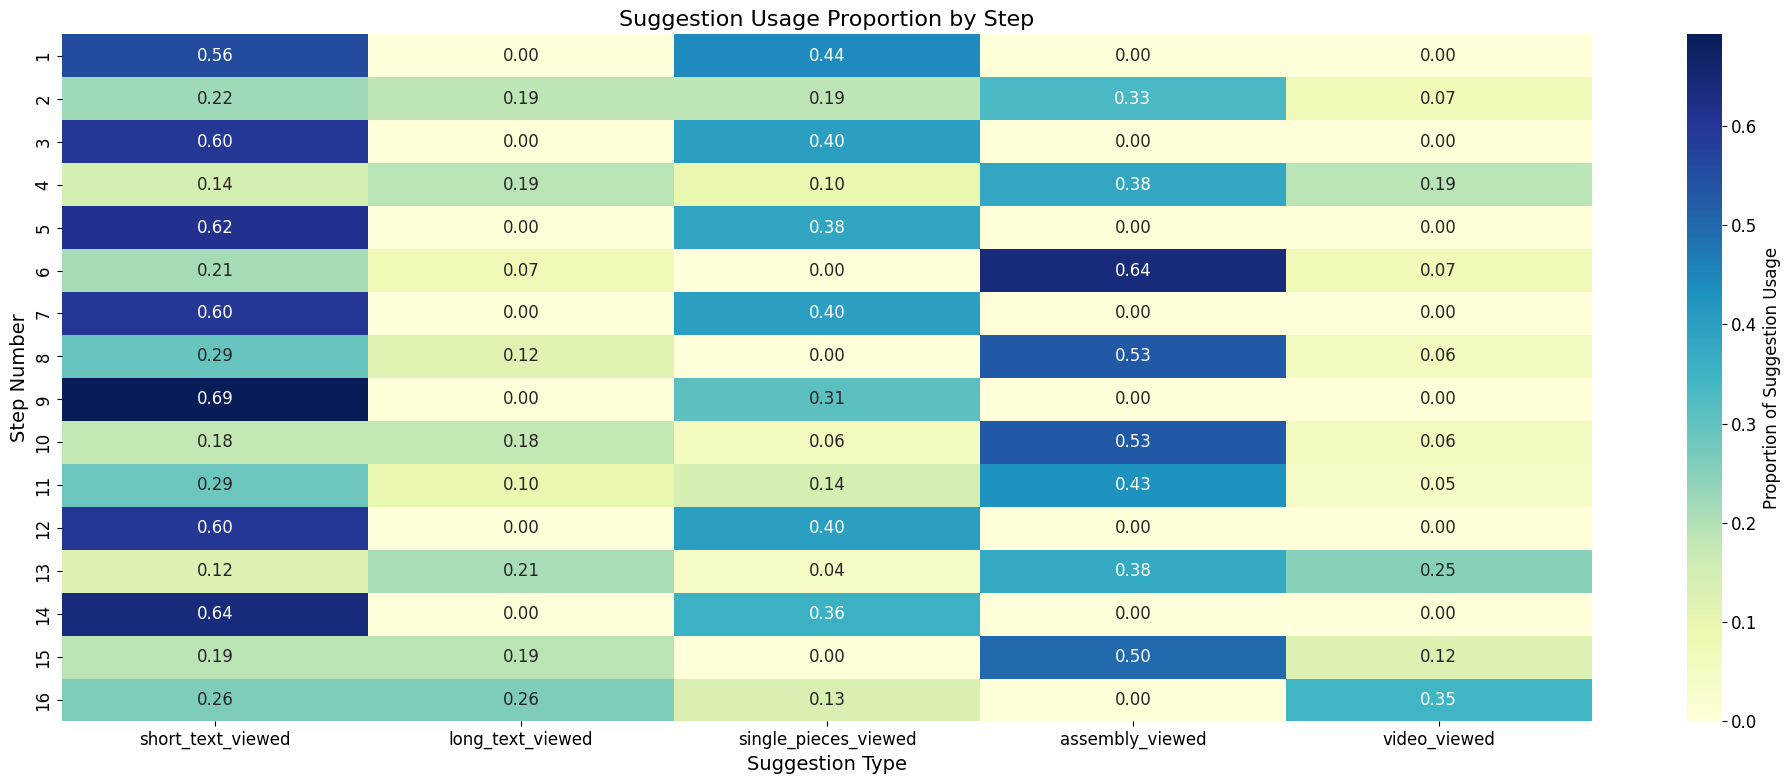

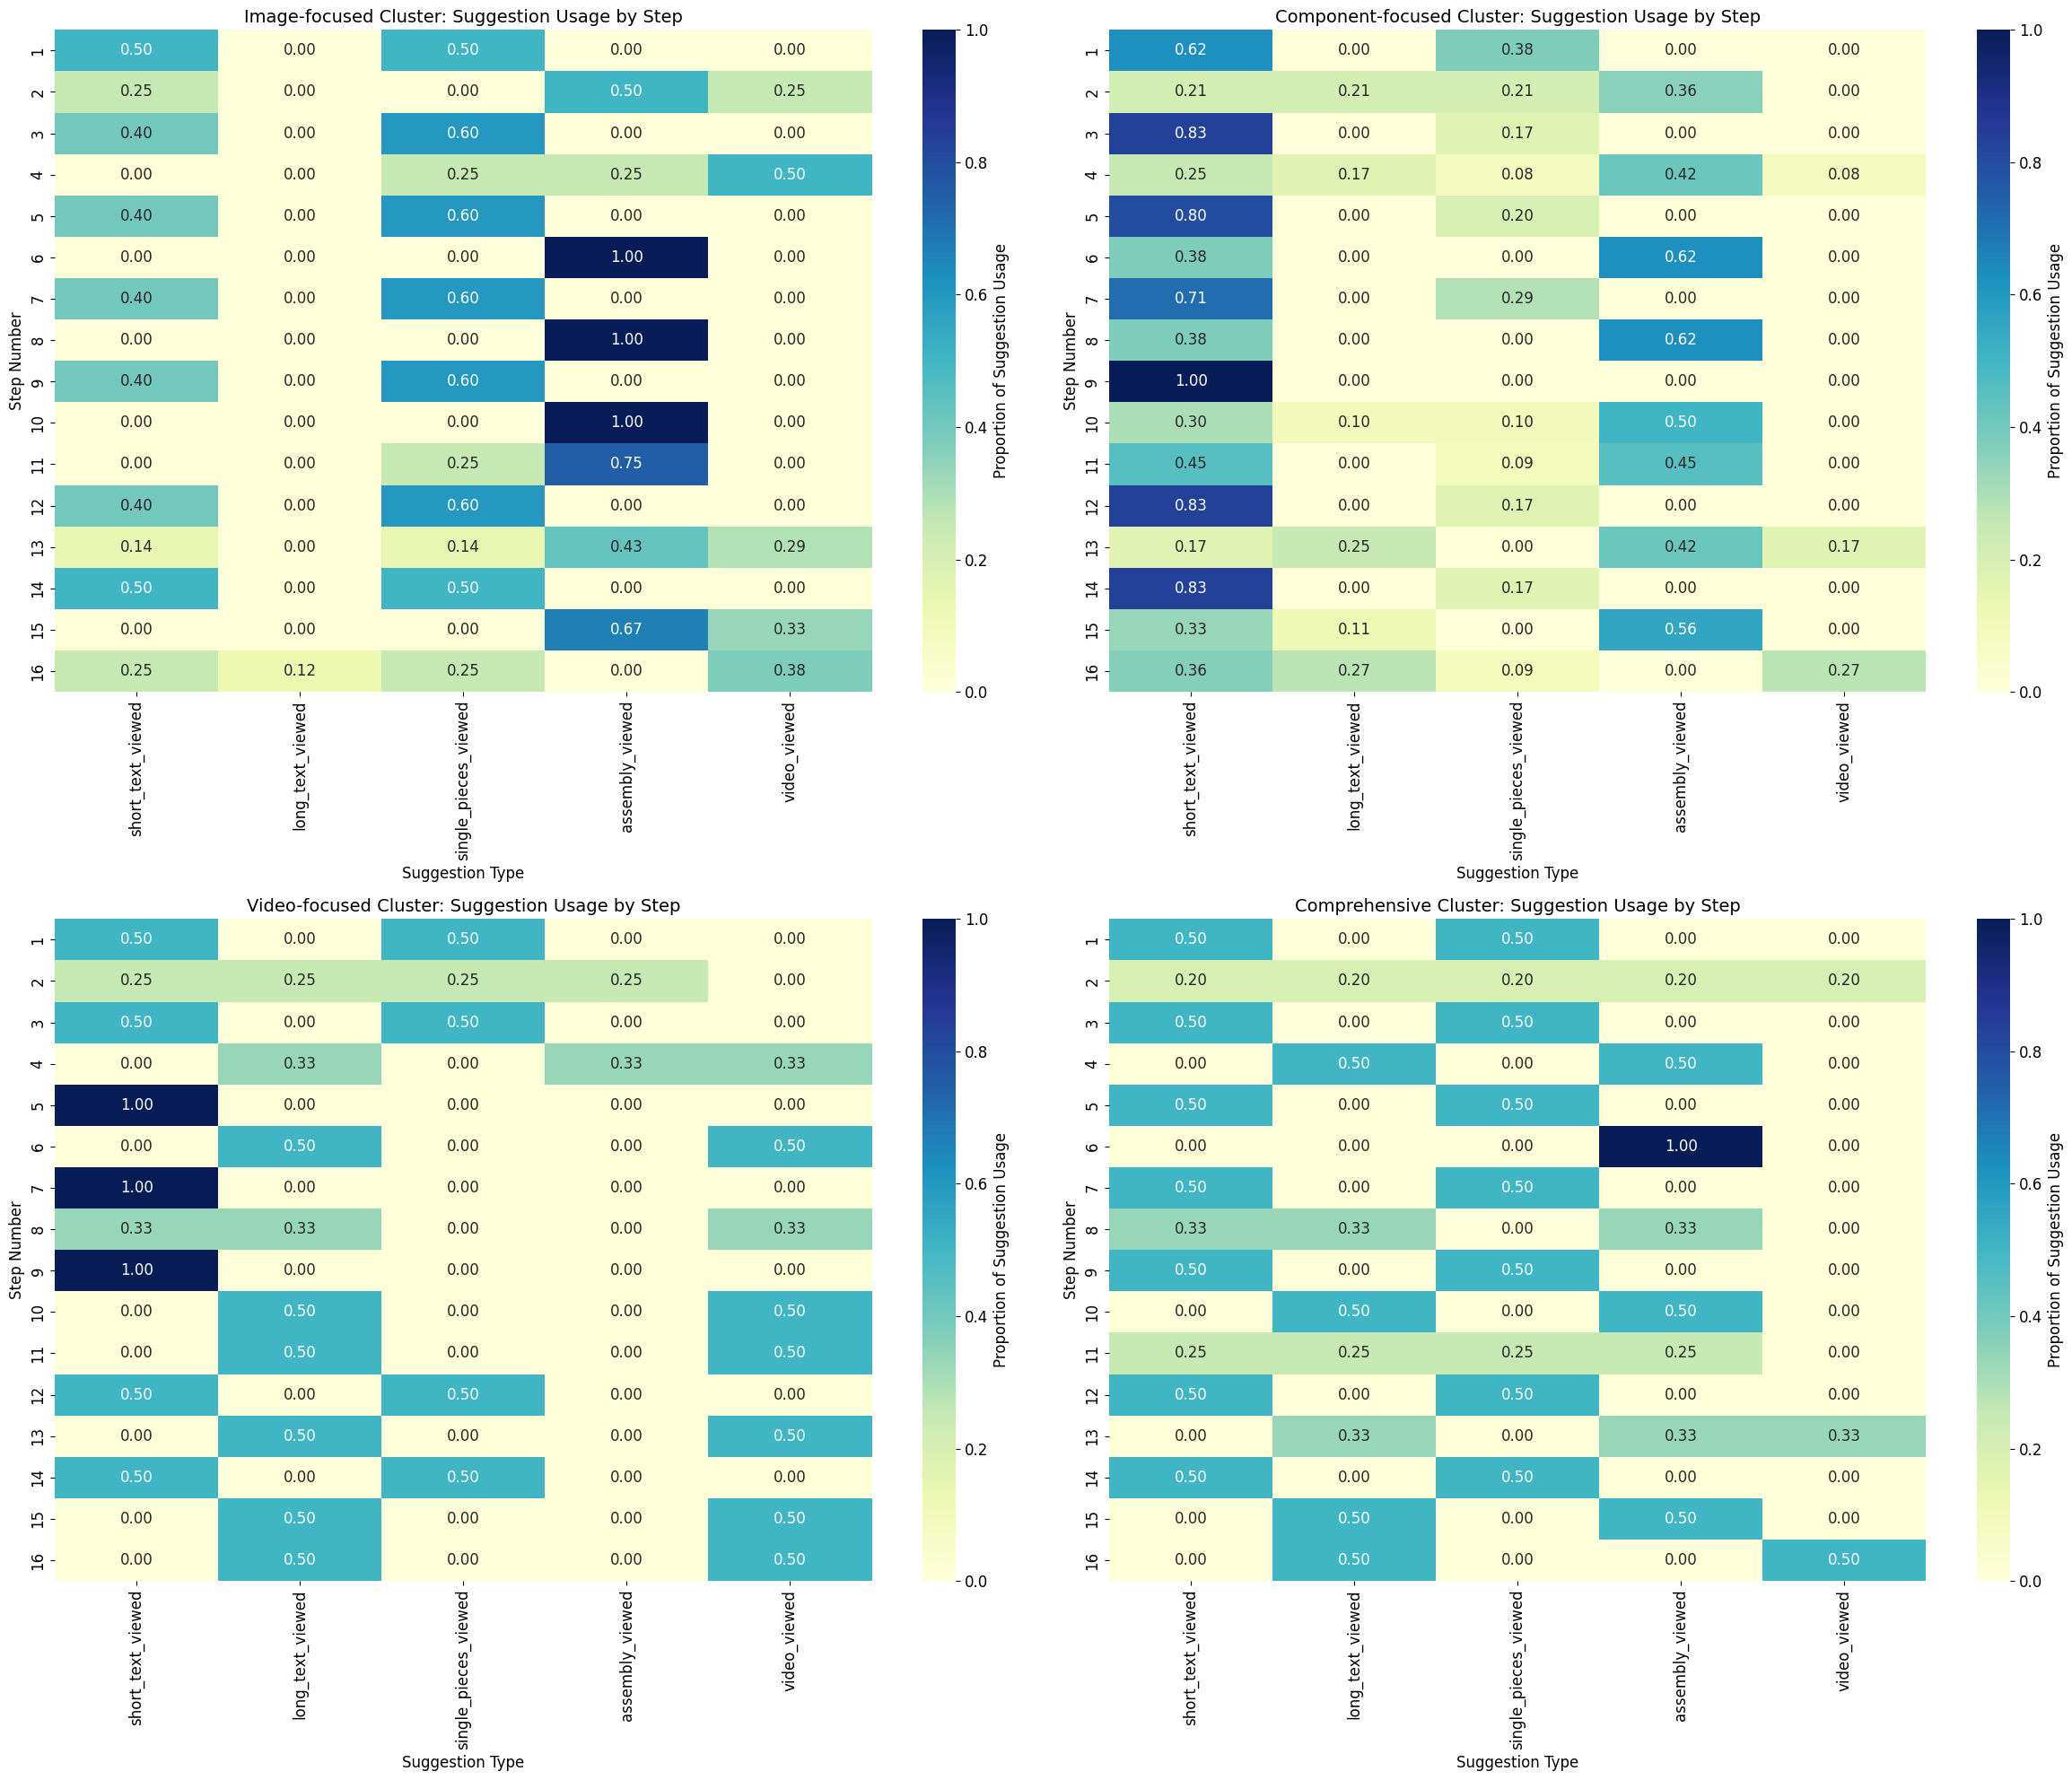

In [ ]:
# Function to get most requested suggestion per step
def get_most_requested_suggestions(data):
    # Reset index to make analysis easier
    data_reset = data.reset_index()

    # Get most requested suggestion for each step
    step_suggestions = {}
    for step in data_reset['step'].unique():
        step_data = data_reset[data_reset['step'] == step]
        suggestion_counts = step_data[suggestion_columns].sum()

        # Create a full breakdown of suggestions for the step
        step_breakdown = suggestion_counts / suggestion_counts.sum()

        step_suggestions[step] = step_breakdown.to_dict()

    return pd.DataFrame.from_dict(step_suggestions, orient='index')

# Perform step-level suggestion analysis
step_suggestion_analysis = get_most_requested_suggestions(data)

# Visualization: Step Suggestion Heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(step_suggestion_analysis,
            cmap='YlGnBu',
            annot=True,
            fmt='.2f',
            cbar_kws={'label': 'Proportion of Suggestion Usage'})
plt.title('Suggestion Usage Proportion by Step', fontsize=16)
plt.xlabel('Suggestion Type', fontsize=14)
plt.ylabel('Step Number', fontsize=14)
plt.tight_layout()
plt.show()

# Cluster-specific step suggestion analysis
def get_cluster_step_suggestions(data, participant_summaries):
    # Define cluster names
    cluster_names = {
        0: "Image-focused",
        1: "Video-focused",
        2: "Component-focused",
        3: "Comprehensive"
    }

    # Dictionary to store results
    cluster_step_suggestions = {}

    # Iterate through clusters
    for cluster in participant_summaries['cluster'].unique():
        cluster_participants = participant_summaries[participant_summaries['cluster'] == cluster].index
        cluster_data = data.reset_index()
        cluster_data = cluster_data[cluster_data['participant_id'].isin(cluster_participants)]

        # Initialize cluster suggestions dictionary
        cluster_suggestions = {}

        # Analyze suggestions for each step
        for step in cluster_data['step'].unique():
            step_data = cluster_data[cluster_data['step'] == step]
            suggestion_counts = step_data[suggestion_columns].sum()

            # Calculate proportion of suggestions
            step_breakdown = suggestion_counts / suggestion_counts.sum()
            cluster_suggestions[step] = step_breakdown.to_dict()

        # Store with cluster name instead of number
        cluster_step_suggestions[cluster_names[cluster]] = pd.DataFrame.from_dict(cluster_suggestions, orient='index')

    return cluster_step_suggestions

# Perform cluster-level step suggestion analysis
cluster_step_suggestion_analysis = get_cluster_step_suggestions(data, participant_summaries)

# Visualization: Cluster Step Suggestion Heatmaps
fig, axes = plt.subplots(2, 2, figsize=(24, 20))
axes = axes.ravel()

for i, (cluster_name, cluster_analysis) in enumerate(cluster_step_suggestion_analysis.items()):
    sns.heatmap(cluster_analysis,
                ax=axes[i],
                cmap='YlGnBu',
                annot=True,
                fmt='.2f',
                cbar_kws={'label': 'Proportion of Suggestion Usage'})
    axes[i].set_title(f'{cluster_name} Cluster: Suggestion Usage by Step', fontsize=14)
    axes[i].set_xlabel('Suggestion Type', fontsize=12)
    axes[i].set_ylabel('Step Number', fontsize=12)

plt.tight_layout()
plt.show()

<Figure size 2000x800 with 0 Axes>

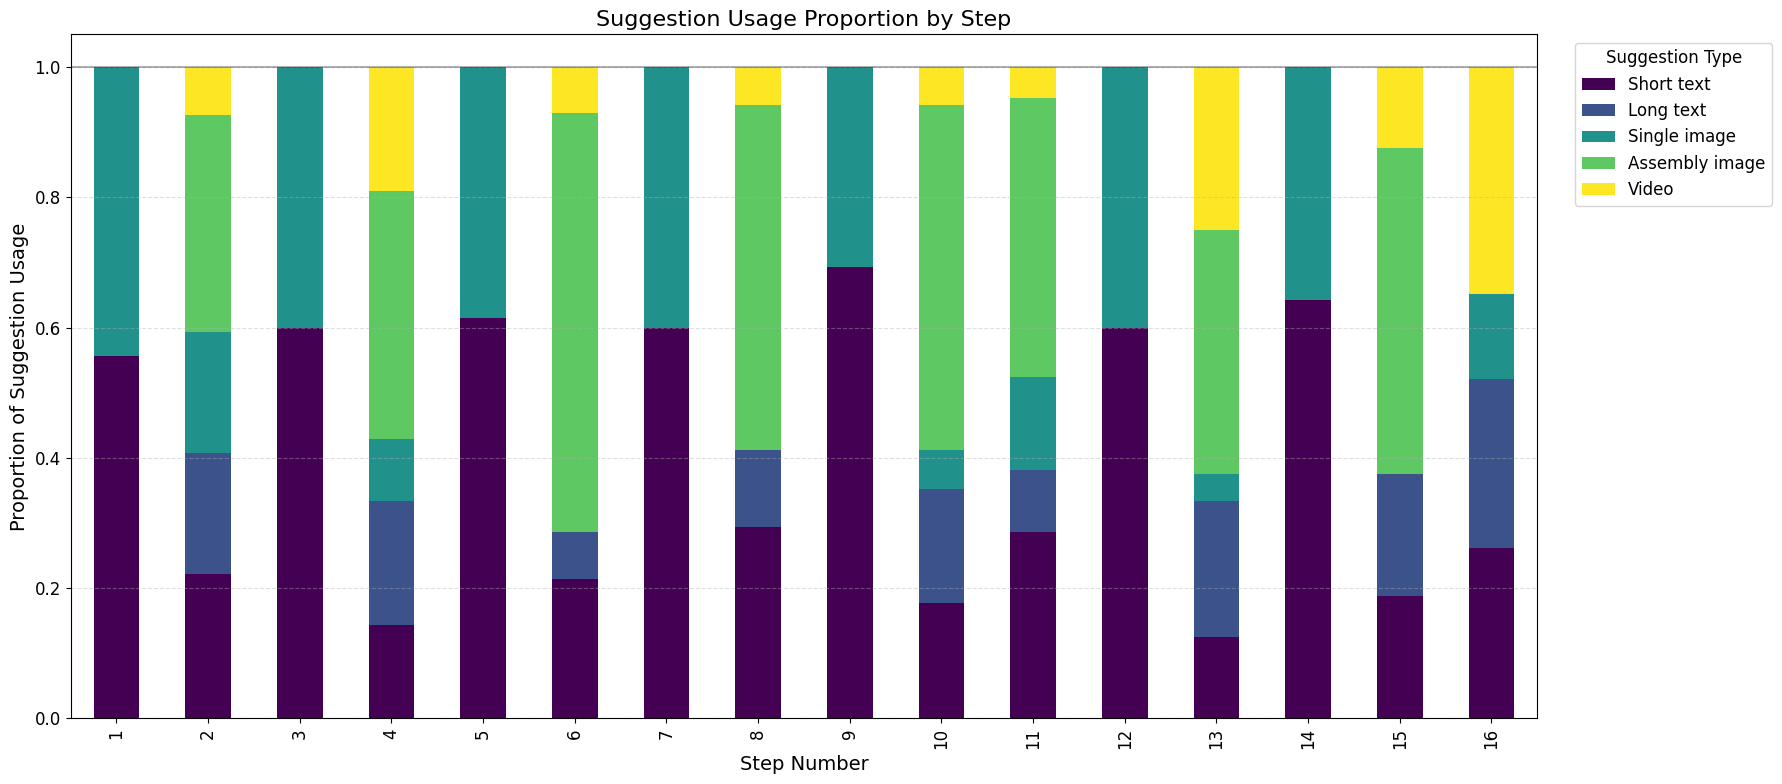

In [ ]:
# Rename the columns with our new names
rename_dict = {
    suggestion_columns[0]: 'Short text',
    suggestion_columns[1]: 'Long text',
    suggestion_columns[2]: 'Single image',
    suggestion_columns[3]: 'Assembly image',
    suggestion_columns[4]: 'Video'
}

# Create a copy of the DataFrame and rename columns
step_suggestion_renamed = step_suggestion_analysis.copy()
step_suggestion_renamed.columns = [rename_dict.get(col, col) for col in step_suggestion_renamed.columns]

# Reorder the columns in the specified order
ordered_columns = ['Short text', 'Long text', 'Single image', 'Assembly image', 'Video']
step_suggestion_renamed = step_suggestion_renamed[ordered_columns]

# Create the stacked bar chart
plt.figure(figsize=(20, 8))
ax = step_suggestion_renamed.plot(
    kind='bar',
    stacked=True,
    figsize=(20, 8),
    colormap='viridis'
)

# Customizing the plot
plt.title('Suggestion Usage Proportion by Step', fontsize=16)
plt.xlabel('Step Number', fontsize=14)
plt.ylabel('Proportion of Suggestion Usage', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(title='Suggestion Type', bbox_to_anchor=(1.02, 1), loc='upper left')

# Add proportion labels to each segment of the stacked bars
# bars = ax.containers
# for container in bars:
#     ax.bar_label(container, label_type='center', fmt='%.2f')

# Add a horizontal line at y=1.0 to indicate 100%
plt.axhline(y=1.0, color='black', linestyle='-', alpha=0.3)

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

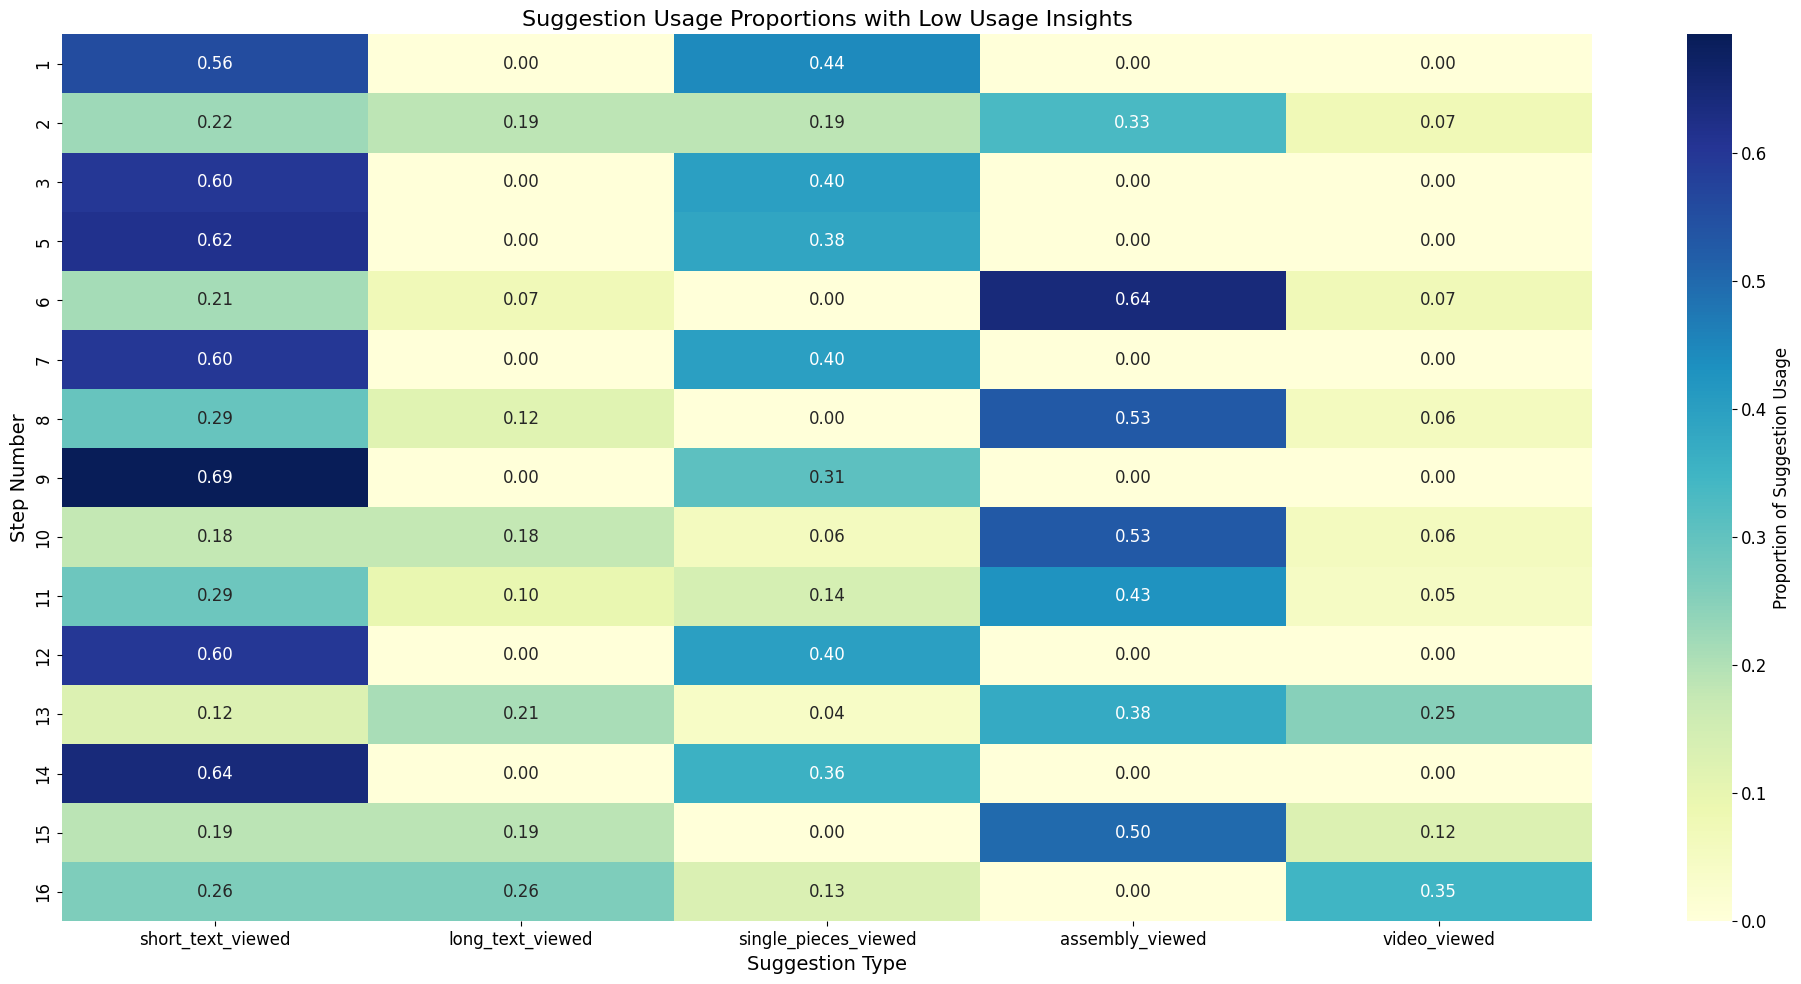

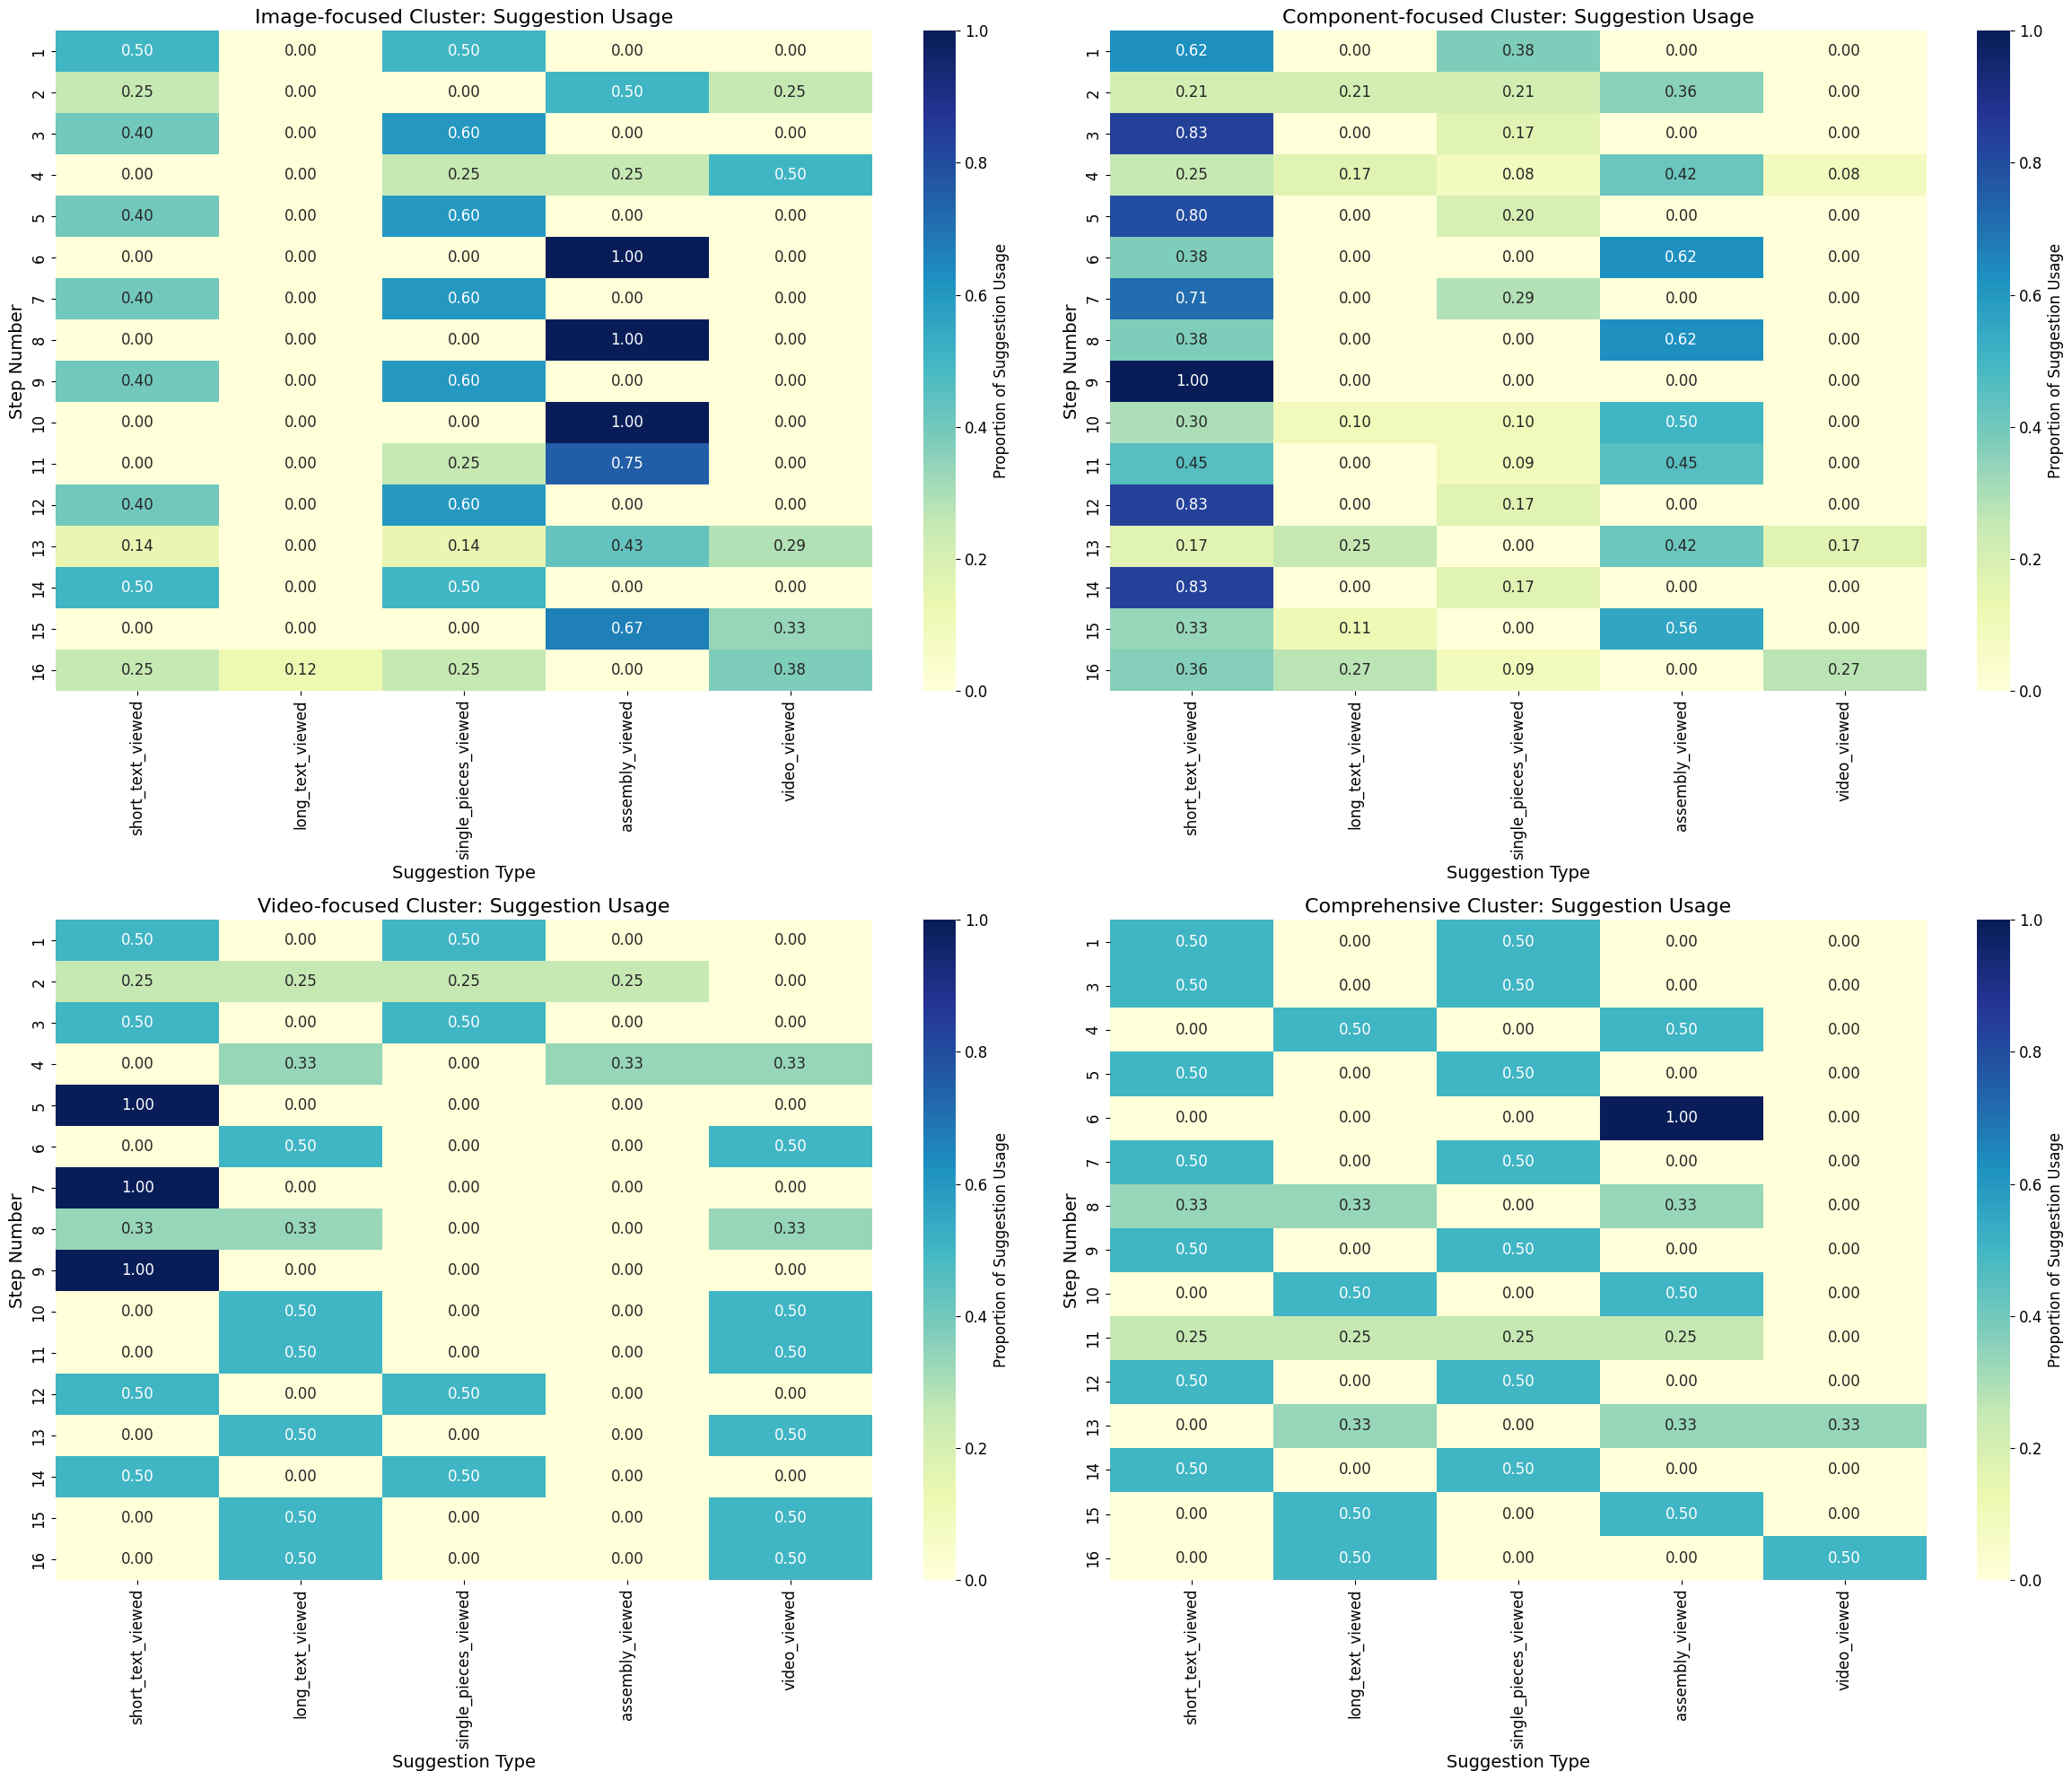

In [ ]:
def analyze_suggestion_usefulness(data):
    # Reset index to make analysis easier
    data_reset = data.reset_index()

    # Initialize a dictionary to store usefulness metrics
    usefulness_analysis = {}

    for step in data_reset['step'].unique():
        step_data = data_reset[data_reset['step'] == step]

        # Calculate total suggestion counts and proportions
        suggestion_counts = step_data[suggestion_columns].sum()
        total_interactions = len(step_data)

        # Calculate suggestion proportions
        if suggestion_counts.sum() > 0:
            suggestion_proportions = suggestion_counts / suggestion_counts.sum()
        else:
            suggestion_proportions = pd.Series({col: 0 for col in suggestion_columns})

        # Define low usage threshold (e.g., below 25% of max usage)
        low_usage_threshold = suggestion_counts.max() * 0.25

        # Identify suggestions used infrequently
        low_usage_suggestions = suggestion_counts[suggestion_counts < low_usage_threshold]

        # If there are low usage suggestions
        if not low_usage_suggestions.empty:
            # Find the most used suggestion among low usage suggestions
            most_useful_low_usage = low_usage_suggestions.idxmax()

            usefulness_analysis[step] = {
                'total_interactions': total_interactions,
                'suggestion_counts': suggestion_counts.to_dict(),
                'suggestion_proportions': suggestion_proportions.to_dict(),
                'most_useful_low_usage': most_useful_low_usage,
                'low_usage_count': low_usage_suggestions[most_useful_low_usage]
            }

    # Convert to DataFrame for easier analysis
    usefulness_df = pd.DataFrame.from_dict(usefulness_analysis, orient='index')

    return usefulness_df

# Perform usefulness analysis
usefulness_analysis = analyze_suggestion_usefulness(data)

# Visualization of usefulness insights
plt.figure(figsize=(20, 10))

# Create a heatmap of suggestion proportions
suggestion_prop_matrix = np.array([list(row['suggestion_proportions'].values())
                                    for _, row in usefulness_analysis.iterrows()])
suggestion_prop_matrix = np.nan_to_num(suggestion_prop_matrix)

sns.heatmap(suggestion_prop_matrix,
            cmap='YlGnBu',
            xticklabels=suggestion_columns,
            yticklabels=usefulness_analysis.index,
            annot=True,
            fmt='.2f',
            cbar_kws={'label': 'Proportion of Suggestion Usage'})

plt.title('Suggestion Usage Proportions with Low Usage Insights', fontsize=16)
plt.xlabel('Suggestion Type', fontsize=14)
plt.ylabel('Step Number', fontsize=14)
plt.tight_layout()
plt.show()

# Detailed insights
# print("\n=== SUGGESTION USEFULNESS INSIGHTS ===")
# print("\nSteps with Interesting Low Usage Suggestion Patterns:")
# for step, row in usefulness_analysis.iterrows():
#     most_useful_low = row['most_useful_low_usage']
#     print(f"\nStep {step}:")
#     print(f"  - Total interactions: {row['total_interactions']}")
#     print("  - Suggestion Counts:")
#     for sug, count in row['suggestion_counts'].items():
#         print(f"    * {sug.replace('_viewed', '')}: {count}")

#     print(f"  - Most Useful Low Usage Suggestion: {most_useful_low.replace('_viewed', '')}")
#     print(f"  - Low Usage Suggestion Count: {row['low_usage_count']}")

# Cluster-specific usefulness analysis
def cluster_usefulness_analysis(data, participant_summaries):
    # Define cluster names
    cluster_names = {
        0: "Image-focused",
        1: "Video-focused",
        2: "Component-focused",
        3: "Comprehensive"
    }

    cluster_usefulness = {}

    for cluster in participant_summaries['cluster'].unique():
        cluster_participants = participant_summaries[participant_summaries['cluster'] == cluster].index
        cluster_data = data.reset_index()
        cluster_data = cluster_data[cluster_data['participant_id'].isin(cluster_participants)]

        # Perform usefulness analysis for this cluster
        cluster_usefulness[cluster_names[cluster]] = analyze_suggestion_usefulness(cluster_data)

    return cluster_usefulness

# Perform cluster-specific usefulness analysis
cluster_usefulness = cluster_usefulness_analysis(data, participant_summaries)

# Visualization of cluster-specific usefulness
plt.figure(figsize=(24, 20))

for i, (cluster_name, cluster_analysis) in enumerate(cluster_usefulness.items(), 1):
    plt.subplot(2, 2, i)

    # Create a heatmap of suggestion proportions
    suggestion_prop_matrix = np.array([list(row['suggestion_proportions'].values())
                                        for _, row in cluster_analysis.iterrows()])
    suggestion_prop_matrix = np.nan_to_num(suggestion_prop_matrix)

    sns.heatmap(suggestion_prop_matrix,
                cmap='YlGnBu',
                xticklabels=suggestion_columns,
                yticklabels=cluster_analysis.index,
                annot=True,
                fmt='.2f',
                cbar_kws={'label': 'Proportion of Suggestion Usage'})

    plt.title(f'{cluster_name} Cluster: Suggestion Usage', fontsize=16)
    plt.xlabel('Suggestion Type', fontsize=14)
    plt.ylabel('Step Number', fontsize=14)

plt.tight_layout()
plt.show()

# Print cluster-specific insights
# print("\n=== CLUSTER-SPECIFIC USEFULNESS INSIGHTS ===")
# for cluster_name, cluster_analysis in cluster_usefulness.items():
#     print(f"\n{cluster_name} Cluster:")
#     for step, row in cluster_analysis.iterrows():
#         most_useful_low = row['most_useful_low_usage']
#         print(f"  Step {step}:")
#         print(f"    - Total interactions: {row['total_interactions']}")
#         print(f"    - Most Useful Low Usage Suggestion: {most_useful_low.replace('_viewed', '')}")
#         print(f"    - Low Usage Suggestion Count: {row['low_usage_count']}")


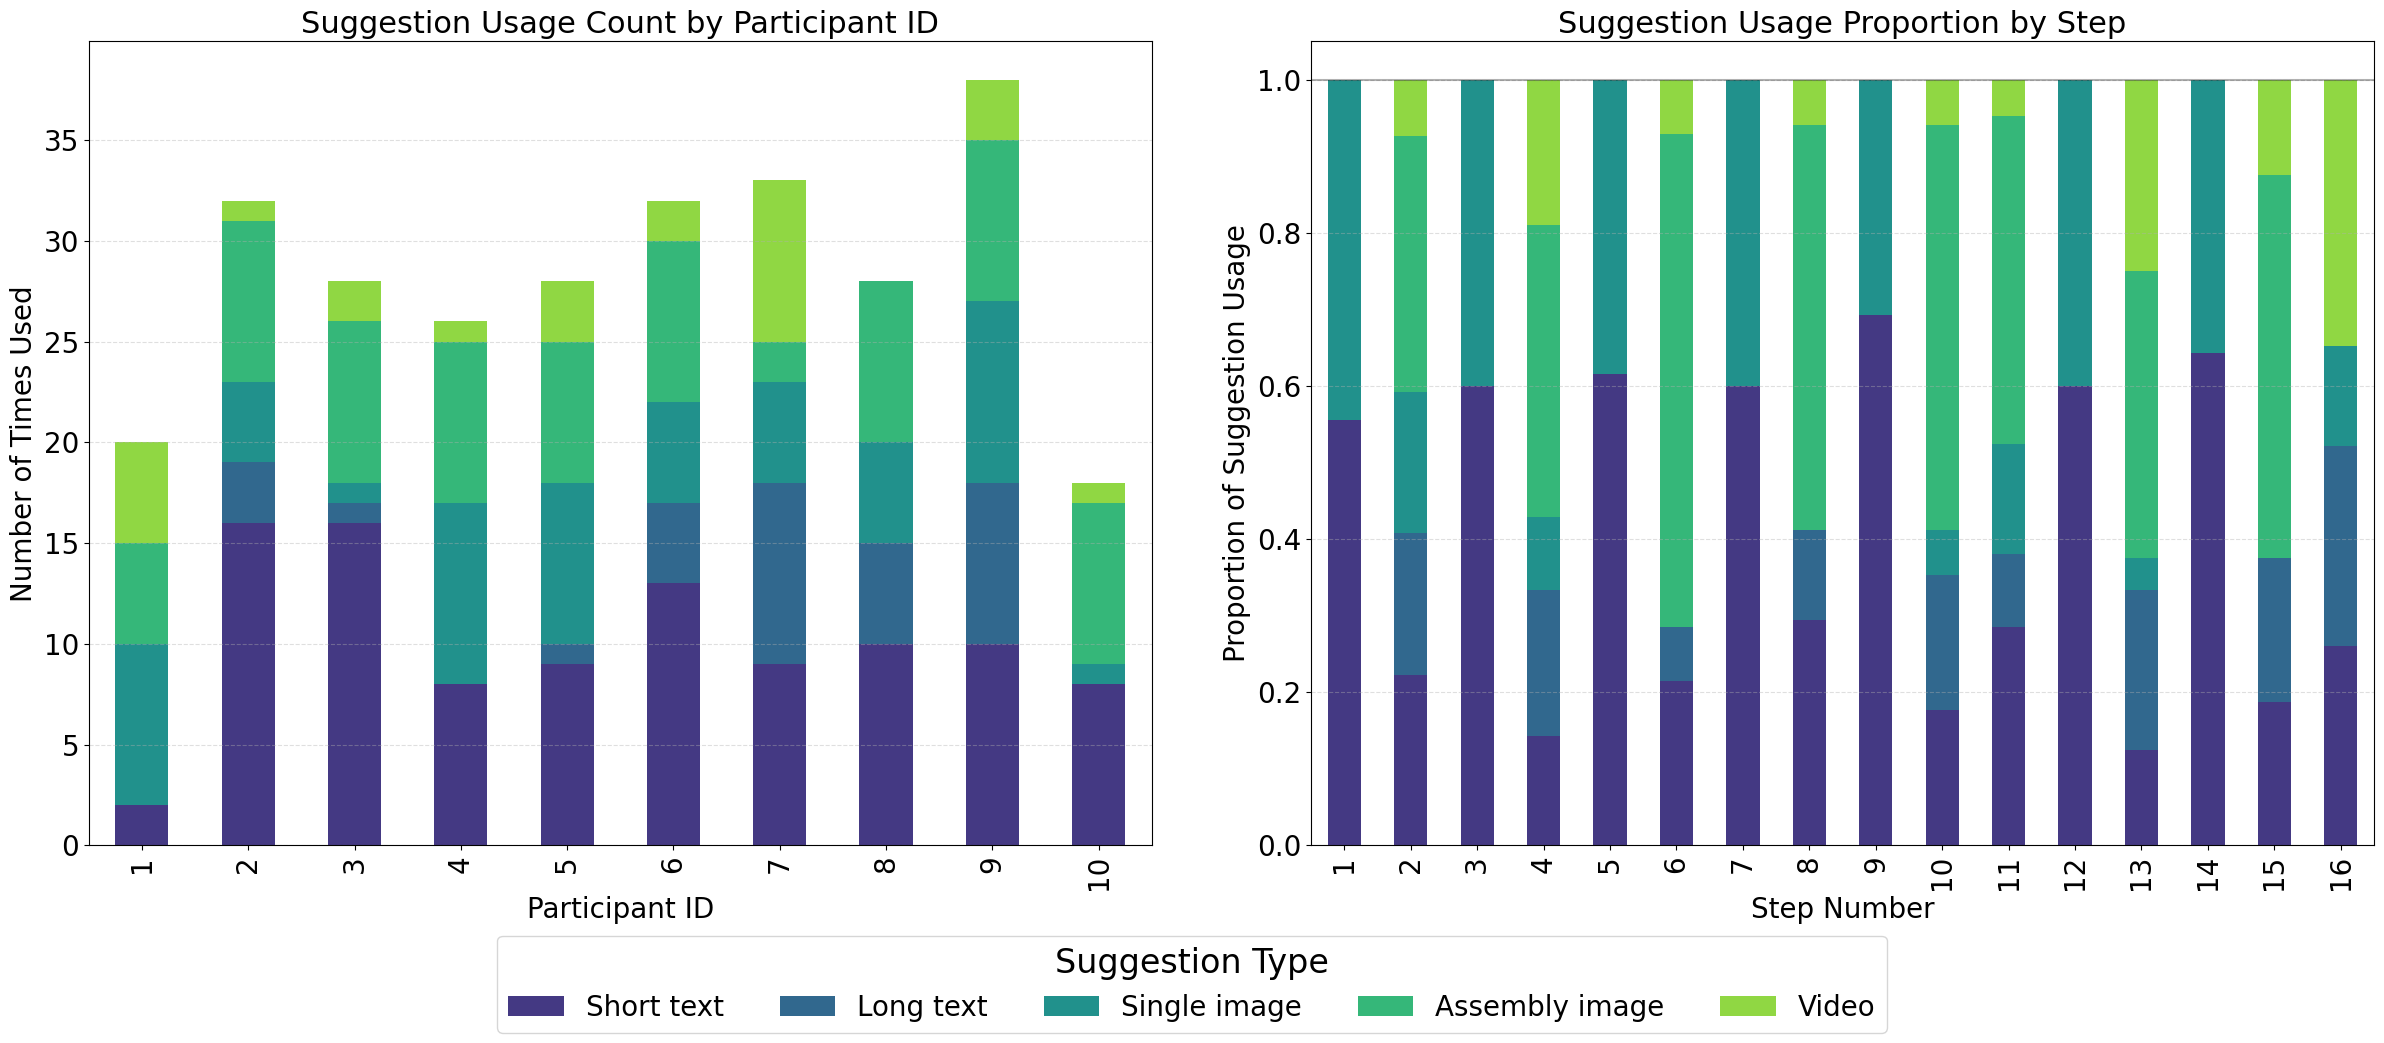

In [ ]:
from matplotlib.gridspec import GridSpec

# Create a copy of the DataFrame and rename columns for step analysis
rename_dict = {
    suggestion_columns[0]: 'Short text',
    suggestion_columns[1]: 'Long text',
    suggestion_columns[2]: 'Single image',
    suggestion_columns[3]: 'Assembly image',
    suggestion_columns[4]: 'Video'
}

colors = sns.color_palette('viridis', n_colors=len(rename_dict))

# Create a large figure with subplots
plt.figure(figsize=(24, 10))
gs = GridSpec(1, 2, width_ratios=[1, 1])

# FIRST SUBPLOT - Participant Suggestion Usage
ax1 = plt.subplot(gs[0])

# Plot the stacked bar chart
pivot_data.plot(
    kind='bar',
    stacked=True,
    color=colors,
    ax=ax1
)

# Customizing the plot
ax1.set_title('Suggestion Usage Count by Participant ID', fontsize=22)
ax1.set_xlabel('Participant ID', fontsize=20)
ax1.set_ylabel('Number of Times Used', fontsize=20)
ax1.grid(axis='y', linestyle='--', alpha=0.4)
ax1.tick_params(axis='both', which='major', labelsize=20)

# Add count labels to each segment of the stacked bars
# bars = ax1.containers
# for container in bars:
#     ax1.bar_label(container, label_type='center', fmt='%g', fontsize=12, fontweight='bold')

# SECOND SUBPLOT - Step Suggestion Proportion
ax2 = plt.subplot(gs[1])

# Create a copy of the DataFrame and rename columns
step_suggestion_renamed = step_suggestion_analysis.copy()
step_suggestion_renamed.columns = [rename_dict.get(col, col) for col in step_suggestion_renamed.columns]

# Reorder the columns in the specified order
step_suggestion_renamed = step_suggestion_renamed[ordered_columns]

# Plot the stacked bar chart for steps
step_suggestion_renamed.plot(
    kind='bar',
    stacked=True,
    color=colors,
    ax=ax2
)

# Customizing the plot
ax2.set_title('Suggestion Usage Proportion by Step', fontsize=22)
ax2.set_xlabel('Step Number', fontsize=20)
ax2.set_ylabel('Proportion of Suggestion Usage', fontsize=20)
ax2.grid(axis='y', linestyle='--', alpha=0.4)
ax2.tick_params(axis='both', which='major', labelsize=20)

# Add proportion labels to each segment of the stacked bars
# bars = ax2.containers
# for container in bars:
#     ax2.bar_label(container, label_type='center', fmt='%.2f', fontsize=12, fontweight='bold')

# Add a horizontal line at y=1.0 to indicate 100%
ax2.axhline(y=1.0, color='black', linestyle='-', alpha=0.3)

# Create a single legend for both plots
handles, labels = ax2.get_legend_handles_labels()
fig = plt.gcf()
fig.legend(handles, labels, title='Suggestion Type',
           title_fontsize=24, fontsize=20,
           loc='upper center', bbox_to_anchor=(0.5, 0.05),
           ncol=5, frameon=True)

# Remove individual legends as we have a common one
ax1.get_legend().remove()
ax2.get_legend().remove()

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.subplots_adjust(wspace=0.15)
plt.show()

In [ ]:
# Key findings and insights
# ========================
print("\n=== KEY FINDINGS ===")
print("\n1. Overall Suggestion Preferences:")
for col in suggestion_columns:
    print(f"  - {col.replace('_viewed', '')}: {data[col].sum()} uses ({data[col].sum() / data[col].count():.1%} of steps)")

print("\n2. Participant Clusters:")
for cluster, name in cluster_names.items():
    members = participant_summaries[participant_summaries['cluster'] == cluster].index.tolist()
    print(f"  - {name}: Participants {members}")

print("\n3. Step Progression Insights:")
early_steps = step_progression.iloc[:5].mean() if len(step_progression) >= 5 else step_progression.iloc[:len(step_progression)//2].mean()
late_steps = step_progression.iloc[-5:].mean() if len(step_progression) >= 5 else step_progression.iloc[len(step_progression)//2:].mean()
changes = late_steps - early_steps
most_increase = changes.idxmax()
most_decrease = changes.idxmin()
print(f"  - Most increasing suggestion: {most_increase.replace('_viewed', '')} (+{changes[most_increase]:.2f})")
print(f"  - Most decreasing suggestion: {most_decrease.replace('_viewed', '')} ({changes[most_decrease]:.2f})")

print("\n4. Co-occurrence Patterns:")
# Find the strongest co-occurrences
co_occur_nodiag = co_occur_df.copy()
np.fill_diagonal(co_occur_nodiag.values, 0)
strongest_pair = np.unravel_index(co_occur_nodiag.values.argmax(), co_occur_nodiag.shape)
print(f"  - Strongest co-occurring suggestions: {co_occur_nodiag.index[strongest_pair[0]]} + {co_occur_nodiag.columns[strongest_pair[1]]}")

print("\n5. Transition Patterns:")
# Find the strongest transitions
strongest_transitions = sorted(all_transitions.items(), key=lambda x: x[1], reverse=True)[:3]
for (source, target), count in strongest_transitions:
    print(f"  - Common transition: {source} → {target} (occurred {count} times)")


=== KEY FINDINGS ===

1. Overall Suggestion Preferences:
  - short_text: 101.0 uses (63.1% of steps)
  - long_text: 31.0 uses (19.4% of steps)
  - single_pieces: 55.0 uses (34.4% of steps)
  - assembly: 70.0 uses (43.8% of steps)
  - video: 26.0 uses (16.2% of steps)

2. Participant Clusters:
  - Image-focused: Participants [1, 4, 5]
  - Video-focused: Participants [7]
  - Component-focused: Participants [2, 3, 6, 8, 10]
  - Comprehensive: Participants [9]

3. Step Progression Insights:
  - Most increasing suggestion: video (+0.20)
  - Most decreasing suggestion: single_pieces (-0.22)

4. Co-occurrence Patterns:
  - Strongest co-occurring suggestions: short_text + single_pieces

5. Transition Patterns:
  - Common transition: assembly → short_text (occurred 53 times)
  - Common transition: short_text → single_pieces (occurred 39 times)
  - Common transition: single_pieces → assembly (occurred 30 times)


In [ ]:
# Recommendations based on the analysis
# ===================================
print("\n=== RECOMMENDATIONS ===")
print("""
1. Interface Design:
   - Position short text and assembly view resources prominently as they're most frequently used together.
   - Create a more intuitive flow between short text and assembly views since this is the most common transition.

2. User Personalization:
   - Implement a system to detect user profile within the first 3-4 interactions.
   - Offer personalized interfaces for the four identified user clusters.

3. Progressive Disclosure:
   - Structure the help system to start with short text for initial orientation.
   - Make assembly views available alongside short text for comprehensive users.
   - Gradually introduce more complex resources like video for specific challenging steps.

4. Video Optimization:
   - Since videos are often used after other resources, ensure they focus on complex assembly steps.
   - Position videos as problem-solving resources rather than primary guidance.

5. Step-specific Resource Emphasis:
   - For early steps, prioritize short text and single pieces views.
   - For middle steps, emphasize assembly views.
   - For final steps, make both short text and assembly views readily available.

6. Adaptive Step-Specific Guidance:
   - Develop a dynamic help system that adjusts resource presentation based on step-level suggestion patterns.
   - Create context-aware interfaces that anticipate user needs at different assembly stages.

7. Personalized Learning Paths:
   - Design cluster-specific resource hierarchies that reflect unique interaction patterns.
   - Implement intelligent suggestion routing based on user cluster and current assembly step.

8. User Experience Optimization:
   - Prioritize resource placement and accessibility based on suggestion usage proportions.
   - Create smooth transitions between different types of suggestions to support diverse learning styles.
""")

# Final conclusions
print("\n=== CONCLUSION ===")
print("""
The analysis reveals distinct user interaction patterns with the furniture assembly help system.
The identification of four user clusters (Assembly-focused, Video and Text learners, Component-focused,
and Comprehensive users) provides a foundation for designing adaptive interfaces.

By understanding the sequential progression of suggestion usage and the co-occurrence patterns,
the help system can be optimized to better support users throughout the assembly process,
potentially reducing assembly time and errors while improving user satisfaction.

Future work should include A/B testing of personalized interfaces based on the identified
user clusters and exploration of machine learning models to predict user needs at specific
assembly steps based on their previous interactions.
""")


=== RECOMMENDATIONS ===

1. Interface Design:
   - Position short text and assembly view resources prominently as they're most frequently used together.
   - Create a more intuitive flow between short text and assembly views since this is the most common transition.

2. User Personalization:
   - Implement a system to detect user profile within the first 3-4 interactions.
   - Offer personalized interfaces for the four identified user clusters.

3. Progressive Disclosure:
   - Structure the help system to start with short text for initial orientation.
   - Make assembly views available alongside short text for comprehensive users.
   - Gradually introduce more complex resources like video for specific challenging steps.

4. Video Optimization:
   - Since videos are often used after other resources, ensure they focus on complex assembly steps.
   - Position videos as problem-solving resources rather than primary guidance.

5. Step-specific Resource Emphasis:
   - For early steps, prior